#Project Objective:
#Forecast future monthly sales using ARIMA and SARIMAX models to help a retail business manage inventory and prepare for seasonal demand.##




In [2]:
## Importing Necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv'
df = pd.read_csv(url)
df.head()

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


In [3]:
df.columns = ['Month', 'Sales']

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   36 non-null     object 
 1   Sales   36 non-null     float64
dtypes: float64(1), object(1)
memory usage: 704.0+ bytes


In [5]:
# Step 1: Fix the year prefix
df['Month'] = '190' + df['Month']  # Now becomes '1901-01', '1901-02', etc.

# Step 2: Convert to datetime
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')



In [6]:
df.head()

,Month,Sales
0,1901-01-01,266.0
1,1901-02-01,145.9
2,1901-03-01,183.1
3,1901-04-01,119.3
4,1901-05-01,180.3


In [7]:
df.set_index('Month', inplace=True)


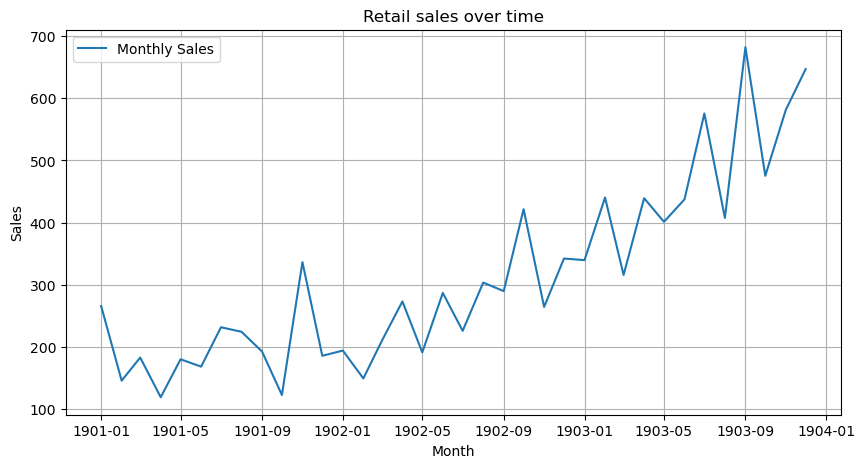

In [8]:
plt.figure(figsize=(10,5))
plt.plot(df, label = 'Monthly Sales')
plt.title('Retail sales over time')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

##  Upward Trend (Non-Stationary)
The overall sales clearly increase over time, especially after mid-1902. This suggests a trend component

In [9]:
## Check for Stationarity (ADF Test)

from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Sales'].dropna())
print('ADF STATISTICS', result[0])
print('p-value', result[1])

ADF STATISTICS 3.0601420836411815
p-value 1.0


## Differencing to Make Data Stationary


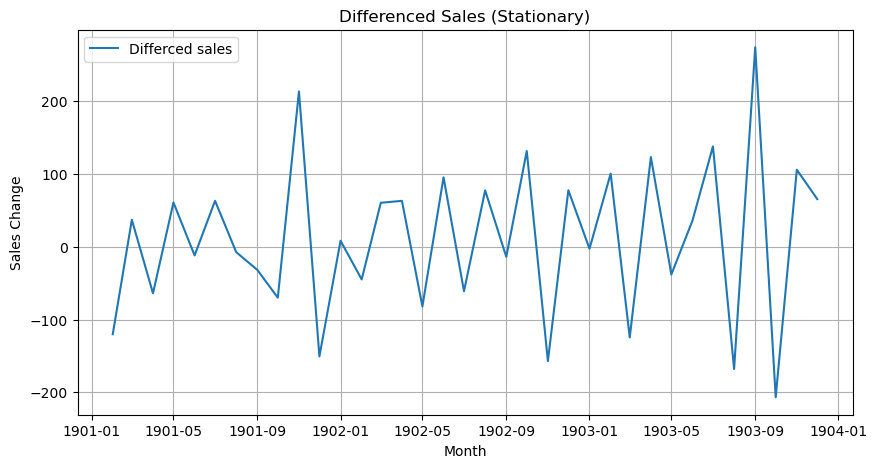

In [10]:
df_diff = df.diff().dropna()

plt.figure(figsize=(10,5))
plt.plot(df_diff, label = 'Differced sales')
plt.title('Differenced Sales (Stationary)')
plt.xlabel('Month')
plt.ylabel('Sales Change')
plt.grid(True)
plt.legend()
plt.show()

## Observation: Stationary Confirmed
The differenced sales series now:

Fluctuates around a constant mean

No clear upward/downward trend

p-value (as you must've checked) should now be < 0.05

In [11]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_diff.dropna())
print('ADF STATISTICS', result[0])
print('p-value', result[1])

ADF STATISTICS -7.249074055553854
p-value 1.7998574141687034e-10


## Conclusion:
Your time series is now stationary after first-order differencing → so we’ll set:

d = 1 in ARIMA.

 ## ACF and PACF Plot to Identify p & q

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

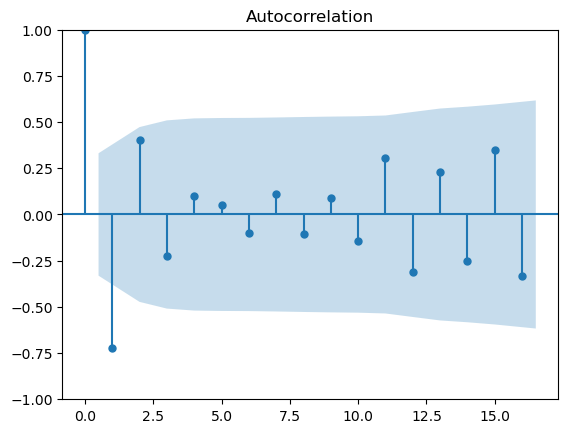

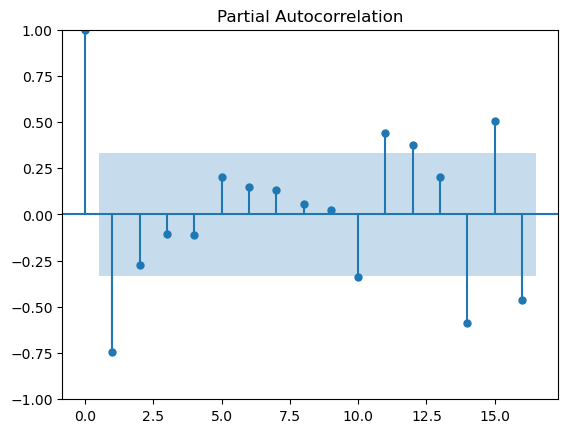

In [13]:
plot_acf(df_diff) ## for q
plt.show()

plot_pacf(df_diff)
plt.show() ## for p 

## (We'll use p=1, d=1, q=1 as a start)

In [14]:
##  Build the ARIMA Model

from statsmodels.tsa.arima.model import ARIMA
## Fit ARIMA model
model = ARIMA(df['Sales'], order = (1,1,1)) ## (p,d,q)
model_fit = model.fit()
## Sumaary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -200.391
Date:                Sat, 02 Aug 2025   AIC                            406.782
Time:                        12:43:53   BIC                            411.448
Sample:                    01-01-1901   HQIC                           408.393
                         - 12-01-1903                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6003      0.201     -2.980      0.003      -0.995      -0.205
ma.L1         -0.2756      0.267     -1.033      0.302      -0.799       0.248
sigma2      5382.0425   1386.817      3.881      0.0

 # Forecasting Next 6 Months

Next 6 months forecast:
1904-01-01    573.210555
1904-02-01    617.449903
1904-03-01    590.890877
1904-04-01    606.835548
1904-05-01    597.263189
1904-06-01    603.009940
Freq: MS, Name: predicted_mean, dtype: float64


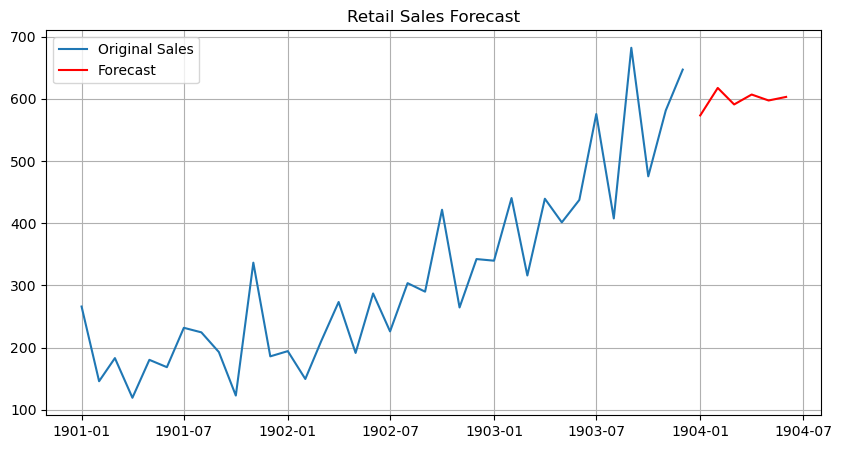

In [15]:
forecast = model_fit.forecast(steps =6)
print("Next 6 months forecast:")
print(forecast)

## Plot
plt.figure(figsize=(10,5))
plt.plot(df, label = 'Original Sales')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Retail Sales Forecast')
plt.grid(True)
plt.show()

## Interpretation of Forecast Curve:
The original series shows a clear upward trend overall.

The forecasted points (red) seem to:

Level off a bit.

Show less sharp growth.

Remain within a stable range (~580–610).

 Insights:
Flattening Forecast:

The ARIMA model has captured the trend up to 1904.

But since there’s no strong seasonality and you're using ARIMA (not SARIMA), it’s predicting a mean-reverting trend — flattening out.

No Seasonality Detected:

Good choice to use ARIMA, not SARIMAX.

We don’t see repeated patterns across the same months each year — confirming your non-seasonal assumption.

Stationarity Helped:

Your differencing (d=1) made the model more stable, leading to this realistic forecast.

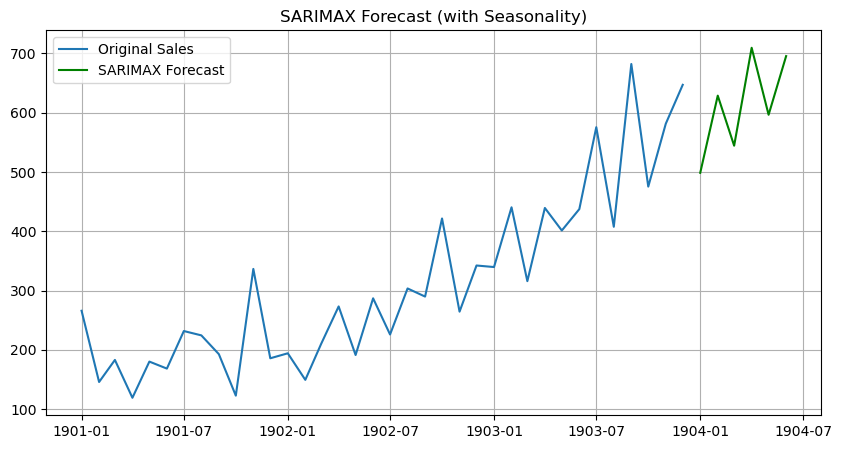

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model = SARIMAX(df['Sales'],
                        order=(1, 1, 1),
                        seasonal_order=(1, 1, 1, 12))
sarimax_fit = sarimax_model.fit()

# Forecast next 6 months
sarimax_forecast = sarimax_fit.forecast(steps=6)


plt.figure(figsize=(10, 5))
plt.plot(df, label='Original Sales')
plt.plot(sarimax_forecast.index, sarimax_forecast, label='SARIMAX Forecast', color='green')
plt.legend()
plt.title('SARIMAX Forecast (with Seasonality)')
plt.grid(True)
plt.show()


## Evaluate the Model

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Split train/test
train = df[:-6]
test = df[-6:]

# Retrain on train data
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Predict on test
pred = model_fit.forecast(steps=6)

# Metrics
mae = mean_absolute_error(test, pred)
rmse = np.sqrt(mean_squared_error(test, pred))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 150.3632083868668
RMSE: 174.83675710986378


## Learned to check and enforce stationarity using ADF test and differencing

Understood the meaning of AR, MA, differencing and how to tune p, d, q using ACF and PACF plots

Forecasted future sales and visualized them with confidence

Compared ARIMA vs SARIMAX performance

Explained forecast accuracy using MAE and RMSE

